In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import imageio
import math
import os

In [ ]:
L1, L2, L3 = 12.0, 13.1, 12.3

In [ ]:
def compute_angles(a, b, c, d):
    print(f"Sides: a={a}, b={b}, c={c}, d={d}")

    # Start with assumed angle between b and c as 30 degrees
    angle_bc = 45

    while angle_bc<180:
        # print(f"Assumed angle between sides b and c: {angle_bc} degrees")

        # Compute the length of the diagonal e
        e = math.sqrt(b**2 + c**2 - 2 * b * c * math.cos(math.radians(angle_bc)))
        # print(f"Calculated length of diagonal e: {e}")

        # Check for validity of the diagonal
        if e > a + d or e > b + c:
            print("Invalid diagonal length. Quadrilateral cannot be formed.")
            return "Invalid diagonal length. Quadrilateral cannot be formed."

        # Using the law of cosines in the two triangles to find all angles
        # Triangle 1: Sides a, d, e
        try:
            angle_ad = math.degrees(math.acos((a**2 + d**2 - e**2) / (2 * a * d)))
            angle_de = math.degrees(math.acos((d**2 + e**2 - a**2) / (2 * d * e)))
            angle_ae = 180 - angle_ad - angle_de
        except ValueError:
            angle_bc += 2
            continue

        # Triangle 2: Sides b, c, e
        try:
            angle_bc = math.degrees(math.acos((b**2 + c**2 - e**2) / (2 * b * c)))
            angle_ce = math.degrees(math.acos((c**2 + e**2 - b**2) / (2 * c * e)))
            angle_be = 180 - angle_bc - angle_ce
        except ValueError:
            angle_bc += 2
            continue
        angle_ab = angle_ae + angle_be
        angle_cd = angle_ce + angle_de

        print(f"Calculated angles: angle_ab={angle_ab}, angle_bc={angle_bc}, angle_cd={angle_cd}, angle_ad={angle_ad}")

        # Check if the sum of angles CE and DE is greater than 90 degrees
        if angle_cd > 90 and angle_cd < 180:
            return angle_ab, angle_bc, angle_cd, angle_ad
        else:
            # Increment assumed angle between b and c by 2 degrees
            angle_bc += 2

    return 90,90,30,135

def inverse_kinematics(x, y, z):
# Function to calculate inverse kinematics
    # x, y, z: Desired position of the end effector

    # Calculate distance from origin to the wrist
    r = math.sqrt(x**2 + y**2)

    # Calculate theta1
    theta1 = math.degrees(math.atan2(y, x))

    a = math.sqrt(r**2 + z**2)

    theta2_, theta3_, theta4_, _ = compute_angles(a,L1,L2,L3)

    theta2 = (theta2_ + math.degrees(math.atan2(z,r)))
    theta3 = theta3_
    theta4 = theta4_
    print(f"Robot angles: axis1={theta1} axis2={theta2}, axis3={theta3}, axis4={theta4}")
    return theta1, theta2, theta3, theta4

In [ ]:
def robot_to(x,y,z,filename="0.png"):
    axis1, axis2, axis3, axis5 = inverse_kinematics(x, y, z)
    axis4 =0
    theta1, theta2, theta3, theta4, theta5 = math.radians(axis1), math.radians(axis2), math.radians(axis3), math.radians(axis4), math.radians(axis5)

    xl1,yl1,zl1 = L1* np.cos(theta1)*np.cos(theta2), L1 * np.sin(theta1)*np.cos(theta2), L1*np.sin(theta2)
    print(f"First Line: {int(xl1)}, {int(yl1)}, {int(zl1)}")
    angle2 = theta3+theta2-np.pi
    xl2, yl2, zl2 = xl1 + np.cos(theta1)*L2*np.cos(angle2),yl1 + np.sin(theta1)*L2*np.cos(angle2), zl1 + L2*np.sin(angle2)
    print(f"Second Line: {int(xl2)}, {int(yl2)}, {int(zl2)}")
    angle3 = 2*np.pi - theta2 -theta3-theta4
    xl3, yl3, zl3 = xl2 - L3* np.cos(theta1)*np.cos(angle3), yl2 - L3*np.sin(theta1)*np.cos(angle3), zl2 + L3*np.sin(angle3)
    print(f"Third Line: {int(xl3)}, {int(yl3)}, {int(zl3)}")

    # Plot the arm configuration
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    ax.set_zlim(0, 30)
    # Plot arm links

    ax.plot([0, xl1 ], [0,yl1 ], [0, zl1], color='blue')  # Link 1
    ax.plot([xl1, xl2 ], [yl1, yl2], [zl1, zl2], color='green')  # Link 2
    ax.plot([xl2, xl3 ], [yl2, yl3], [zl2, zl3], color='red')  # Link 3

    ax.scatter(x, y, z, color='orange', label='Point')

    ax.scatter(0, 0, 0, color='black')
    ax.scatter(xl1, yl1, zl1, color='blue')
    ax.scatter(xl2, yl2, zl2, color='green')
    ax.scatter(xl3, yl3, zl3, color='red')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('SCARA 6-Axis Arm Configuration')
    ax.legend()

    gap = np.sqrt((xl3-x)**2 + (yl3-y)**2 + (zl3-z)**2)
    print(f"Gap Distance: {int(gap*10)} mm")

    ax.text(x=30, y=30, z=30, s=f"Gap: {int(gap*10)} mm", fontsize=12, color='red', ha='right', va='top')
    plt.savefig(filename)
    plt.show()
    print(f"Saved image to {filename}")

    CL1 = np.sqrt((xl3-xl2)**2 + (yl3-yl2)**2 + (zl3-zl2)**2)
    CL2 = np.sqrt((xl2-xl1)**2 + (yl2-yl1)**2 + (zl2-zl1)**2)
    CL3 = np.sqrt((xl1)**2 + (yl1)**2 + (zl1)**2)

    robo1 = axis1
    robo2 = 210 - axis2
    robo3 = 30 + axis3
    robo4 = 90 + axis4
    robo5 = 270 - axis5

    print(f"Robot Angles: {robo1}, {robo2}, {robo3}, {robo4}, {robo5}")

    return filename

In [ ]:
def process_coordinates(data):
    IMAGES = []

    delay = data.get('delay', 0)  # Default delay is 0 if not specified

    for index, coord in enumerate(data.get('coordinates', [])):  # Default to an empty list if 'c>
        x = coord.get('x')
        y = coord.get('y')
        z = coord.get('z')

        # Calculate servo angles
        IMAGES.append(robot_to(x, y, z, f"{index}.png"))

        # Wait for the specified delay before processing the next set of coordi>
        time.sleep(delay)

    return IMAGES, delay

In [ ]:
# def create_video(IMAGES, delay=1):
#   # Create an imageio writer to save the frames as a video
#   fps = int(1/delay)
#   print(f"processing {IMAGES} into a {fps} fps video")
#   output_file = 'robot_video.mp4'

#   # Read images and create video frames
#   video_frames = [imageio.imread(str(image)) for image in IMAGES]

#   # Create video
#   imageio.mimsave(output_file, video_frames, fps=10)

#   print(f'Video saved as: {output_file}')
#   return output_file

In [ ]:
# data = {
# "delay": 0.05,
# "coordinates": [
# {
#     "x": 0,
#     "y": 10,
#     "z": 15
# },{
#     "x": 0,
#     "y": 22,
#     "z": 16
# },
# {
#     "x": 0,
#     "y": 23,
#     "z": 17
# },
# {
#     "x": 0,
#     "y": 24,
#     "z": 18
# },
# {
#     "x": 0,
#     "y": 25,
#     "z": 19
# },{
#     "x": 0,
#     "y": 26,
#     "z": 20
# },{
#     "x": 0,
#     "y": 27,
#     "z": 21
# },{
#     "x": 0,
#     "y": 28,
#     "z": 22
# },{
#     "x": 0,
#     "y": 29,
#     "z": 23
# },{
#     "x": 0,
#     "y": 30,
#     "z": 24
# },{
#     "x": 0,
#     "y": 30,
#     "z": 30
# },
# {
#     "x": 0,
#     "y": 30,
#     "z": 30
# }
# ]
# }

# images, delay = process_coordinates(data)


# video = create_video(images, delay)

### rectangle coordinates

In [ ]:
import os
import imageio

def create_rectangle_video(IMAGES, delay=1, video_output_dir='rectangle_videos', images_output_dir='rectangle_images'):
    # Create output directories if they don't exist
    if not os.path.exists(video_output_dir):
        os.makedirs(video_output_dir)
    if not os.path.exists(images_output_dir):
        os.makedirs(images_output_dir)

    # Create an imageio writer to save the frames as a video
    fps = int(1/delay)
    print(f"processing {len(IMAGES)} images into a {fps} fps video")
    video_filename = os.path.join(video_output_dir, 'robot_video.mp4')

    # Read images and create video frames
    video_frames = [imageio.imread(str(image)) for image in IMAGES]

    # Create video
    imageio.mimsave(video_filename, video_frames, fps=10)

    print(f'Video saved as: {video_filename}')

    # Saving images separately
    for idx, image_path in enumerate(IMAGES):
        image = imageio.imread(str(image_path))  # Read image data
        image_filename = os.path.join(images_output_dir, f'image_{idx}.png')
        imageio.imwrite(image_filename, image)
        print(f'Image {idx+1} saved as: {image_filename}')

    return video_filename


{
    "delay": 0.05,
    "coordinates": [
        {
            "x": 0,
            "y": 20,
            "z": 0
        },
        {
            "x": 1,
            "y": 20,
            "z": 0
        },
        {
            "x": 2,
            "y": 20,
            "z": 0
        },
        {
            "x": 3,
            "y": 20,
            "z": 0
        },
        {
            "x": 4,
            "y": 20,
            "z": 0
        },
        {
            "x": 5,
            "y": 20,
            "z": 0
        },
        {
            "x": 6,
            "y": 20,
            "z": 0
        },
        {
            "x": 7,
            "y": 20,
            "z": 0
        },
        {
            "x": 8,
            "y": 20,
            "z": 0
        },
        {
            "x": 9,
            "y": 20,
            "z": 0
        },
        {
            "x": 10,
            "y": 20,
            "z": 0
        },
        {
            "x": 10,
            "y": 19,
            "z

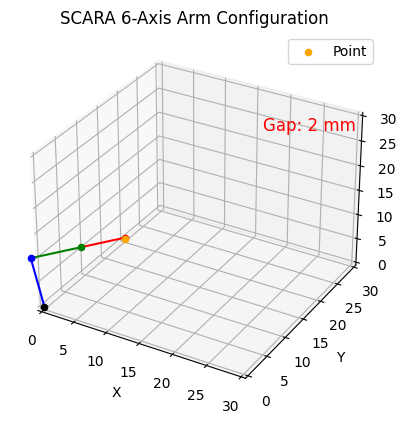

Saved image to 0.png
Robot Angles: 90.0, 107.84494984998683, 81.0, 90, 91.37056385997045
Sides: a=20.024984394500787, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=101.08019214954716, angle_bc=45.0, angle_cd=192.629305306483, angle_ad=21.290502543969865
Calculated angles: angle_ab=101.68163383795584, angle_bc=47.0, angle_cd=187.62748497798347, angle_ad=23.690881184060697
Calculated angles: angle_ab=101.9723482695455, angle_bc=49.00000000000001, angle_cd=183.0770119741396, angle_ad=25.950639756314906
Calculated angles: angle_ab=102.02141729375882, angle_bc=51.00000000000001, angle_cd=178.87605011423938, angle_ad=28.102532592001793
Robot angles: axis1=87.13759477388825 axis2=102.02141729375882, axis3=51.00000000000001, axis4=178.87605011423938
First Line: 0, -2, 11
Second Line: 0, 9, 5
Third Line: 1, 20, 0
Gap Distance: 2 mm


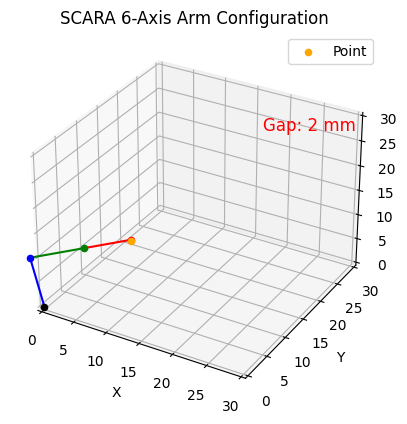

Saved image to 1.png
Robot Angles: 87.13759477388825, 107.97858270624118, 81.0, 90, 91.12394988576062
Sides: a=20.09975124224178, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=100.5263528458482, angle_bc=45.0, angle_cd=193.5974841395668, angle_ad=20.876163014585018
Calculated angles: angle_ab=101.19055507683628, angle_bc=47.0, angle_cd=188.500923483449, angle_ad=23.308521439714763
Calculated angles: angle_ab=101.53008573221518, angle_bc=49.00000000000001, angle_cd=183.87805915202924, angle_ad=25.591855115755582
Calculated angles: angle_ab=101.61868618648984, angle_bc=51.00000000000001, angle_cd=179.61955938608284, angle_ad=27.761754427427327
Robot angles: axis1=84.28940686250037 axis2=101.61868618648984, axis3=51.00000000000001, axis4=179.61955938608284
First Line: 0, -2, 11
Second Line: 0, 9, 5
Third Line: 2, 20, 0
Gap Distance: 0 mm


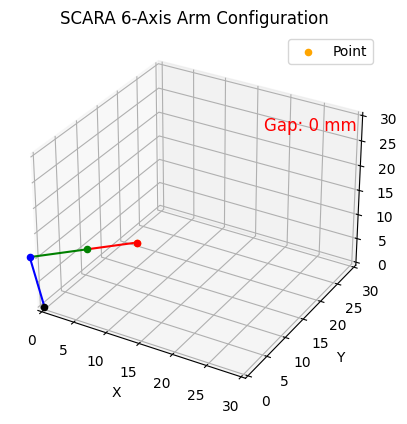

Saved image to 2.png
Robot Angles: 84.28940686250037, 108.38131381351016, 81.0, 90, 90.38044061391716
Sides: a=20.223748416156685, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=99.58505590120795, angle_bc=45.0, angle_cd=195.2450301164002, angle_ad=20.169913982391858
Calculated angles: angle_ab=100.35979093068235, angle_bc=47.0, angle_cd=189.98014261505068, angle_ad=22.66006645426697
Calculated angles: angle_ab=100.78425866184767, angle_bc=49.00000000000001, angle_cd=185.23019306702088, angle_ad=24.985548271131435
Calculated angles: angle_ab=100.941052546139, angle_bc=51.00000000000001, angle_cd=180.8715325584963, angle_ad=27.187414895364704
Calculated angles: angle_ab=100.8859430830241, angle_bc=53.000000000000014, angle_cd=176.82170792116153, angle_ad=29.292348995814375
Robot angles: axis1=81.46923439005187 axis2=100.8859430830241, axis3=53.000000000000014, axis4=176.82170792116153
First Line: 0, -2, 11
Second Line: 1, 9, 6
Third Line: 3, 20, 0
Gap Distance: 6 mm


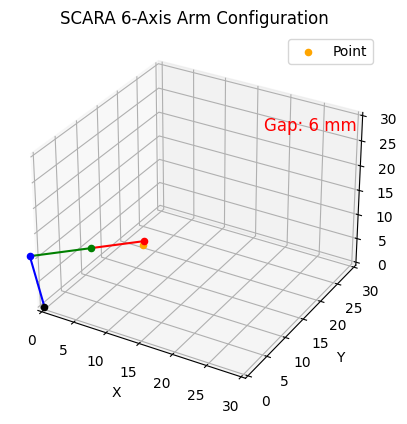

Saved image to 3.png
Robot Angles: 81.46923439005187, 109.1140569169759, 83.00000000000001, 90, 93.17829207883847
Sides: a=20.396078054371138, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=98.22413981238019, angle_bc=45.0, angle_cd=197.63137236300133, angle_ad=19.14448782461845
Calculated angles: angle_ab=99.16814969436638, angle_bc=47.0, angle_cd=192.10531683938183, angle_ad=21.72653346625181
Calculated angles: angle_ab=99.72006458727147, angle_bc=49.00000000000001, angle_cd=187.1621343876111, angle_ad=24.11780102511746
Calculated angles: angle_ab=99.97774148431643, angle_bc=51.00000000000001, angle_cd=182.65328944284107, angle_ad=26.368969072842514
Calculated angles: angle_ab=100.00537156741211, angle_bc=53.000000000000014, angle_cd=178.48262926371393, angle_ad=28.511999168873963
Robot angles: axis1=78.69006752597979 axis2=100.00537156741211, axis3=53.000000000000014, axis4=178.48262926371393
First Line: 0, -2, 11
Second Line: 1, 9, 5
Third Line: 4, 20, 0
Gap Distance: 3 mm


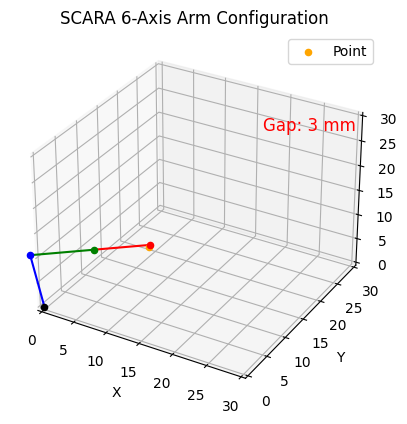

Saved image to 4.png
Robot Angles: 78.69006752597979, 109.99462843258789, 83.00000000000001, 90, 91.51737073628607
Sides: a=20.615528128088304, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=96.38620901961697, angle_bc=45.0, angle_cd=200.86174141348903, angle_ad=17.752049566894012
Calculated angles: angle_ab=97.57928467572691, angle_bc=47.0, angle_cd=194.9447577184651, angle_ad=20.475957605807995
Calculated angles: angle_ab=98.31274648383115, angle_bc=49.00000000000001, angle_cd=189.72148159549326, angle_ad=22.965771920675603
Calculated angles: angle_ab=98.7110349718789, angle_bc=51.00000000000001, angle_cd=184.9995696168067, angle_ad=25.289395411314423
Calculated angles: angle_ab=98.85219668019614, angle_bc=53.000000000000014, angle_cd=180.6600890764186, angle_ad=27.487714243385245
Calculated angles: angle_ab=98.78914330546593, angle_bc=55.000000000000014, angle_cd=176.62344849797188, angle_ad=29.587408196562155
Robot angles: axis1=75.96375653207353 axis2=98.78914330546593, axis3=

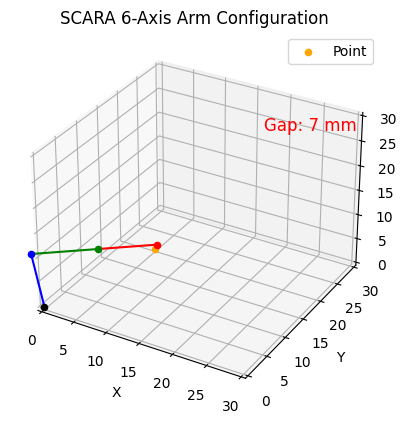

Saved image to 5.png
Robot Angles: 75.96375653207353, 111.21085669453407, 85.00000000000001, 90, 93.37655150202812
Sides: a=20.8806130178211, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=93.9664530289234, angle_bc=45.0, angle_cd=205.1267768189852, angle_ad=15.906770152091406
Calculated angles: angle_ab=95.53111722502149, angle_bc=47.0, angle_cd=198.6141025335284, angle_ad=18.854780241450097
Calculated angles: angle_ab=96.52171896942852, angle_bc=49.00000000000001, angle_cd=192.98552712158505, angle_ad=21.492753908986423
Calculated angles: angle_ab=97.11266505390613, angle_bc=51.00000000000001, angle_cd=187.9652716418907, angle_ad=23.922063304203203
Calculated angles: angle_ab=97.40583221325542, angle_bc=53.000000000000014, angle_cd=183.39470979837688, angle_ad=26.199457988367694
Calculated angles: angle_ab=97.46715771501259, angle_bc=55.000000000000014, angle_cd=179.17260400485807, angle_ad=28.360238280129323
Robot angles: axis1=73.30075576600639 axis2=97.46715771501259, axis3=55

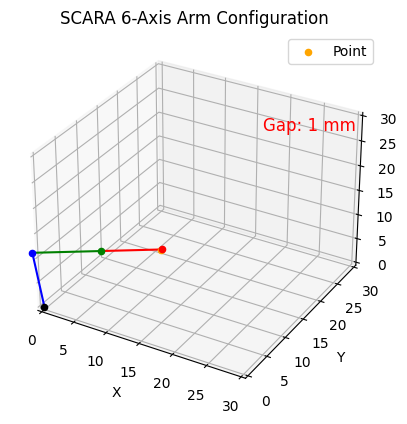

Saved image to 6.png
Robot Angles: 73.30075576600639, 112.53284228498741, 85.00000000000001, 90, 90.82739599514193
Sides: a=21.18962010041709, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=90.7526477098586, angle_bc=45.0, angle_cd=210.80978762839698, angle_ad=13.437564661744435
Calculated angles: angle_ab=92.91185978495784, angle_bc=47.0, angle_cd=203.3199114538145, angle_ad=16.768228761227636
Calculated angles: angle_ab=94.27864557053579, angle_bc=49.00000000000001, angle_cd=197.0832841118994, angle_ad=19.638070317564825
Calculated angles: angle_ab=95.13703508898406, angle_bc=51.00000000000001, angle_cd=191.63816956844505, angle_ad=22.224795342570886
Calculated angles: angle_ab=95.63403454214529, angle_bc=53.000000000000014, angle_cd=186.74959899689145, angle_ad=24.61636646096326
Calculated angles: angle_ab=95.85809536309164, angle_bc=55.000000000000014, angle_cd=182.27834508832558, angle_ad=26.863559548582757
Calculated angles: angle_ab=95.8675891250028, angle_bc=57.000000000000

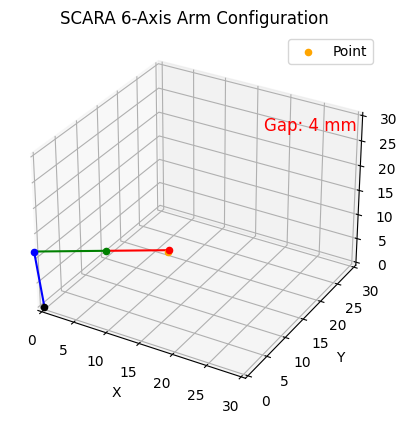

Saved image to 7.png
Robot Angles: 70.70995378081128, 114.1324108749972, 87.00000000000001, 90, 91.86618950158078
Sides: a=21.540659228538015, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=86.19863811514132, angle_bc=45.0, angle_cd=218.8917609088403, angle_ad=9.909600976018398
Calculated angles: angle_ab=89.49455660940163, angle_bc=47.0, angle_cd=209.47881623759503, angle_ad=14.026627153003355
Calculated angles: angle_ab=91.46010989698823, angle_bc=49.00000000000001, angle_cd=202.24607378121314, angle_ad=17.293816321798634
Calculated angles: angle_ab=92.70734399927379, angle_bc=51.00000000000001, angle_cd=196.16501289505175, angle_ad=20.127643105674483
Calculated angles: angle_ab=93.48493006864209, angle_bc=53.000000000000014, angle_cd=190.82558187634143, angle_ad=22.68948805501649
Calculated angles: angle_ab=93.92491830450454, angle_bc=55.000000000000014, angle_cd=186.0136820713974, angle_ad=25.06139962409803
Calculated angles: angle_ab=94.10798064502947, angle_bc=57.000000000000

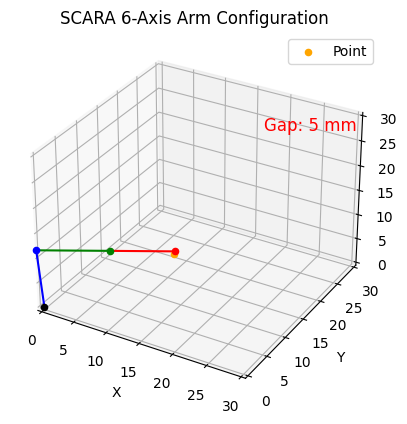

Saved image to 8.png
Robot Angles: 68.19859051364818, 115.91209120367617, 89.0, 90, 92.49857124262394
Sides: a=21.93171219946131, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=76.76151046793917, angle_bc=45.0, angle_cd=235.70885408714742, angle_ad=2.5296354449133953
Calculated angles: angle_ab=84.6813989929548, angle_bc=47.0, angle_cd=218.18294074895795, angle_ad=10.135660258087249
Calculated angles: angle_ab=87.81040731979621, angle_bc=49.00000000000001, angle_cd=208.9505472908756, angle_ad=14.23904538932821
Calculated angles: angle_ab=89.68282132369986, angle_bc=51.00000000000001, angle_cd=201.8132403430193, angle_ad=17.503938333280832
Calculated angles: angle_ab=90.87028142414914, angle_bc=53.000000000000014, angle_cd=195.79322976835036, angle_ad=20.3364888075005
Calculated angles: angle_ab=91.60770287198612, angle_bc=55.000000000000014, angle_cd=190.4962194867829, angle_ad=22.896077641230967
Calculated angles: angle_ab=92.02051459100909, angle_bc=57.000000000000014, angle_cd=1

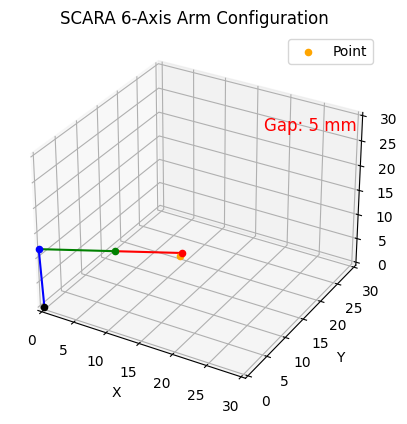

Saved image to 9.png
Robot Angles: 65.77225468204583, 117.84558778976024, 91.0, 90, 92.75567298940507
Sides: a=22.360679774997898, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=82.61519845727486, angle_bc=49.00000000000001, angle_cd=218.52315756157364, angle_ad=9.861643981151508
Calculated angles: angle_ab=85.76075374046219, angle_bc=51.00000000000001, angle_cd=209.1555845546261, angle_ad=14.083661704911714
Calculated angles: angle_ab=87.62414591120316, angle_bc=53.000000000000014, angle_cd=201.97204667403727, angle_ad=17.40380741475958
Calculated angles: angle_ab=88.80266389715716, angle_bc=55.000000000000014, angle_cd=195.92897749633215, angle_ad=20.26835860651067
Calculated angles: angle_ab=89.53476765595829, angle_bc=57.000000000000014, angle_cd=190.6176333827781, angle_ad=22.847598961263607
Calculated angles: angle_ab=89.94611148741592, angle_bc=59.00000000000001, angle_cd=185.82632998047725, angle_ad=25.227558532106826
Calculated angles: angle_ab=90.11315675333533, angle_bc=

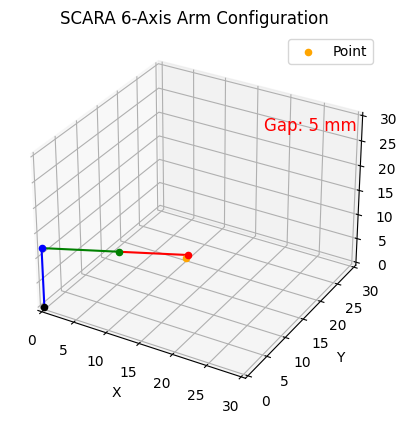

Saved image to 10.png
Robot Angles: 63.43494882292201, 119.91321212502065, 93.00000000000001, 90, 92.65953762736683
Sides: a=21.470910553583888, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=87.22046242969607, angle_bc=45.0, angle_cd=217.0758118293375, angle_ad=10.703725740966409
Calculated angles: angle_ab=90.22253249035563, angle_bc=47.0, angle_cd=208.1651634971484, angle_ad=14.612304012495962
Calculated angles: angle_ab=92.04807265258435, angle_bc=49.00000000000001, angle_cd=201.16792647613434, angle_ad=17.784000871281304
Calculated angles: angle_ab=93.20849792287409, angle_bc=51.00000000000001, angle_cd=195.23047310008224, angle_ad=20.561028977043687
Calculated angles: angle_ab=93.9251128946178, angle_bc=53.000000000000014, angle_cd=189.99017562892948, angle_ad=23.084711476452735
Calculated angles: angle_ab=94.31900593074187, angle_bc=55.000000000000014, angle_cd=185.25188142465544, angle_ad=25.429112644602657
Calculated angles: angle_ab=94.4654785708665, angle_bc=57.000000000

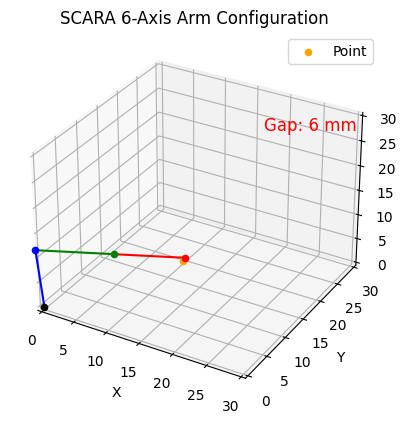

Saved image to 11.png
Robot Angles: 62.24145939893998, 115.58466334944728, 89.0, 90, 93.15683144248234
Sides: a=20.591260281974, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=96.59600449510542, angle_bc=45.0, angle_cd=200.49258398800782, angle_ad=17.911411516886748
Calculated angles: angle_ab=97.75933445898164, angle_bc=47.0, angle_cd=194.6226713633484, angle_ad=20.61799417766998
Calculated angles: angle_ab=98.47149607977047, angle_bc=49.00000000000001, angle_cd=189.43253343827718, angle_ad=23.09597048195236
Calculated angles: angle_ab=98.85348002178424, angle_bc=51.00000000000001, angle_cd=184.73553964192777, angle_ad=25.410980336287988
Calculated angles: angle_ab=98.98158688620384, angle_bc=53.000000000000014, angle_cd=180.41564187458744, angle_ad=27.60277123920872
Calculated angles: angle_ab=98.90773609281345, angle_bc=55.000000000000014, angle_cd=176.39488451402377, angle_ad=29.69737939316274
Robot angles: axis1=60.94539590092286 axis2=98.90773609281345, axis3=55.0000000000000

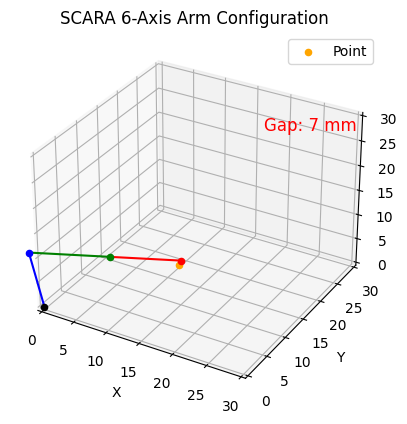

Saved image to 12.png
Robot Angles: 60.94539590092286, 111.09226390718655, 85.00000000000001, 90, 93.60511548597623
Sides: a=19.72308292331602, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=103.22466073136262, angle_bc=45.0, angle_cd=188.88942919732023, angle_ad=22.885910071317152
Calculated angles: angle_ab=103.59722673113843, angle_bc=47.0, angle_cd=184.22752461872676, angle_ad=25.17524865013483
Calculated angles: angle_ab=103.70642281066114, angle_bc=49.00000000000001, angle_cd=179.94178885425788, angle_ad=27.35178833508097
Robot angles: axis1=59.53445508054013 axis2=103.70642281066114, axis3=49.00000000000001, axis4=179.94178885425788
First Line: -1, -2, 11
Second Line: 4, 7, 5
Third Line: 10, 17, 0
Gap Distance: 0 mm


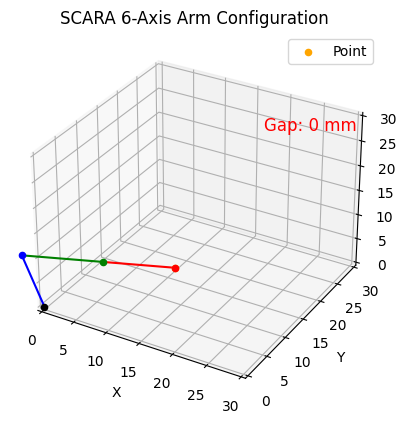

Saved image to 13.png
Robot Angles: 59.53445508054013, 106.29357718933886, 79.0, 90, 90.05821114574212
Sides: a=18.867962264113206, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=108.69467419442189, angle_bc=45.0, angle_cd=179.42303285374965, angle_ad=26.882292951828475
Robot angles: axis1=57.9946167919165 axis2=108.69467419442189, axis3=45.0, axis4=179.42303285374965
First Line: -2, -3, 11
Second Line: 4, 6, 5
Third Line: 10, 16, 0
Gap Distance: 1 mm


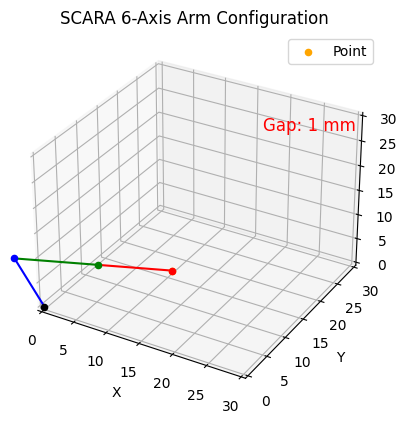

Saved image to 14.png
Robot Angles: 57.9946167919165, 101.30532580557811, 75.0, 90, 90.57696714625035
Sides: a=18.027756377319946, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=113.48224151983412, angle_bc=45.0, angle_cd=171.24165584205093, angle_ad=30.276102638114935
Robot angles: axis1=56.309932474020215 axis2=113.48224151983412, axis3=45.0, axis4=171.24165584205093
First Line: -2, -3, 11
Second Line: 4, 6, 6
Third Line: 10, 15, 1
Gap Distance: 18 mm


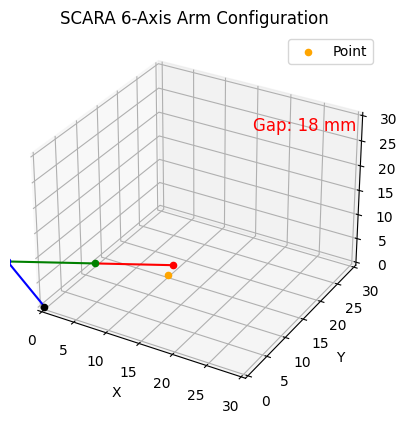

Saved image to 15.png
Robot Angles: 56.309932474020215, 96.51775848016588, 75.0, 90, 98.75834415794907
Sides: a=17.4928556845359, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=116.32473136697391, angle_bc=45.0, angle_cd=166.43953918993444, angle_ad=32.23572944309164
Robot angles: axis1=59.03624346792648 axis2=116.32473136697391, axis3=45.0, axis4=166.43953918993444
First Line: -2, -4, 10
Second Line: 3, 6, 6
Third Line: 9, 16, 2
Gap Distance: 29 mm


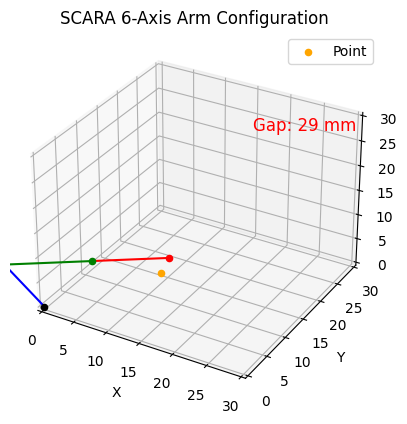

Saved image to 16.png
Robot Angles: 59.03624346792648, 93.67526863302609, 75.0, 90, 103.56046081006556
Sides: a=17.0, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=118.83773463401754, angle_bc=45.0, angle_cd=162.23359348612257, angle_ad=33.92867187985987
Robot angles: axis1=61.92751306414704 axis2=118.83773463401754, axis3=45.0, axis4=162.23359348612257
First Line: -2, -5, 10
Second Line: 3, 5, 6
Third Line: 8, 16, 3
Gap Distance: 37 mm


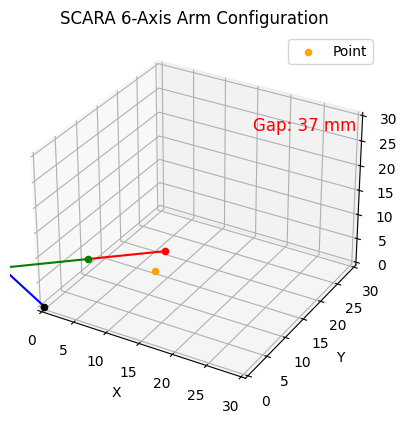

Saved image to 17.png
Robot Angles: 61.92751306414704, 91.16226536598246, 75.0, 90, 107.76640651387743
Sides: a=16.55294535724685, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=121.04610173093505, angle_bc=45.0, angle_cd=158.57147126687278, angle_ad=35.382427002192166
Robot angles: axis1=64.98310652189998 axis2=121.04610173093505, axis3=45.0, axis4=158.57147126687278
First Line: -2, -5, 10
Second Line: 2, 5, 7
Third Line: 7, 16, 4
Gap Distance: 45 mm


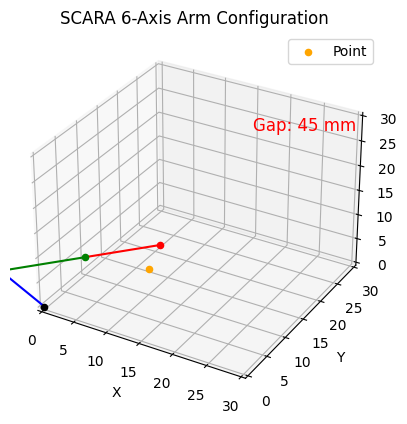

Saved image to 18.png
Robot Angles: 64.98310652189998, 88.95389826906495, 75.0, 90, 111.42852873312722
Sides: a=16.15549442140351, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=122.9625127327366, angle_bc=45.0, angle_cd=155.42165379320983, angle_ad=36.615833474053574
Robot angles: axis1=68.19859051364818 axis2=122.9625127327366, axis3=45.0, axis4=155.42165379320983
First Line: -2, -6, 10
Second Line: 2, 5, 7
Third Line: 6, 17, 4
Gap Distance: 52 mm


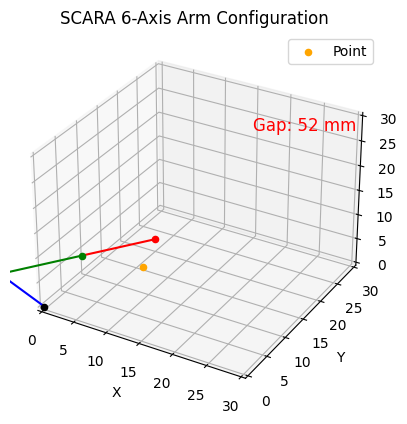

Saved image to 19.png
Robot Angles: 68.19859051364818, 87.0374872672634, 75.0, 90, 114.57834620679017
Sides: a=15.811388300841896, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=124.59168863401557, angle_bc=45.0, angle_cd=152.76614753246548, angle_ad=37.64216383351898
Robot angles: axis1=71.56505117707799 axis2=124.59168863401557, axis3=45.0, axis4=152.76614753246548
First Line: -2, -6, 9
Second Line: 1, 5, 7
Third Line: 5, 17, 5
Gap Distance: 57 mm


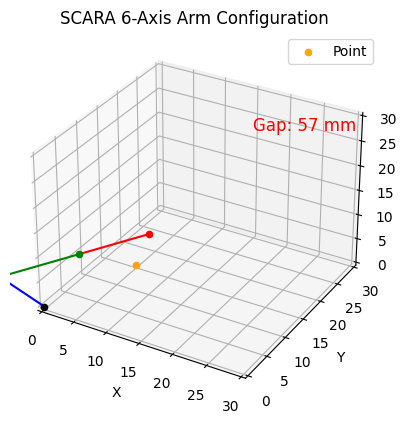

Saved image to 20.png
Robot Angles: 71.56505117707799, 85.40831136598443, 75.0, 90, 117.23385246753452
Sides: a=15.524174696260024, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=125.93323899333836, angle_bc=45.0, angle_cd=150.59580355538674, angle_ad=38.470957451274884
Robot angles: axis1=75.06858282186245 axis2=125.93323899333836, axis3=45.0, axis4=150.59580355538674
First Line: -1, -6, 9
Second Line: 1, 5, 7
Third Line: 4, 17, 5
Gap Distance: 62 mm


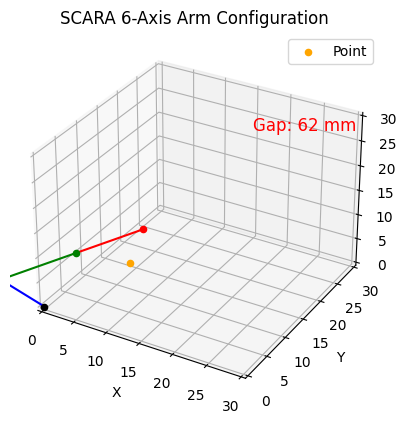

Saved image to 21.png
Robot Angles: 75.06858282186245, 84.06676100666164, 75.0, 90, 119.40419644461326
Sides: a=15.297058540778355, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=126.98381100241916, angle_bc=45.0, angle_cd=148.90705937264613, angle_ad=39.10912962493471
Robot angles: axis1=78.69006752597979 axis2=126.98381100241916, axis3=45.0, axis4=148.90705937264613
First Line: -1, -7, 9
Second Line: 1, 5, 7
Third Line: 3, 17, 6
Gap Distance: 65 mm


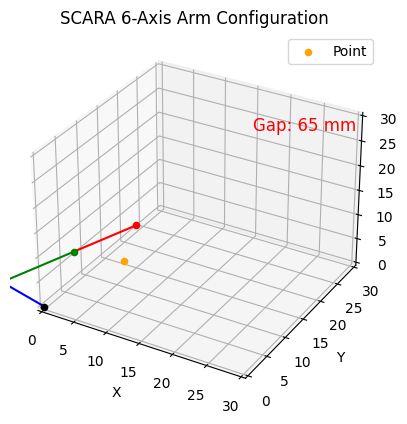

Saved image to 22.png
Robot Angles: 78.69006752597979, 83.01618899758084, 75.0, 90, 121.09294062735387
Sides: a=15.132745950421556, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=127.73882895574644, angle_bc=45.0, angle_cd=147.69953868442943, angle_ad=39.56163235982414
Robot angles: axis1=82.40535663140857 axis2=127.73882895574644, axis3=45.0, axis4=147.69953868442943
First Line: 0, -7, 9
Second Line: 0, 5, 7
Third Line: 2, 17, 6
Gap Distance: 68 mm


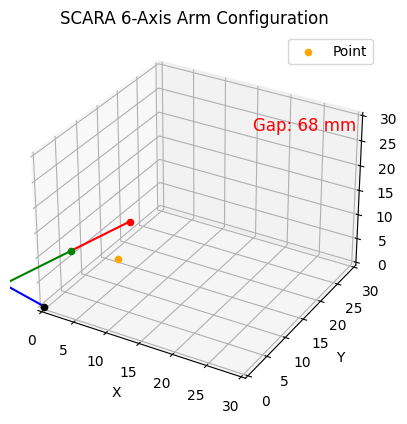

Saved image to 23.png
Robot Angles: 82.40535663140857, 82.26117104425356, 75.0, 90, 122.30046131557057
Sides: a=15.033296378372908, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=128.19391578548232, angle_bc=45.0, angle_cd=146.974256941227, angle_ad=39.83182727329071
Robot angles: axis1=86.18592516570965 axis2=128.19391578548232, axis3=45.0, axis4=146.974256941227
First Line: 0, -7, 9
Second Line: 0, 5, 7
Third Line: 1, 17, 6
Gap Distance: 69 mm


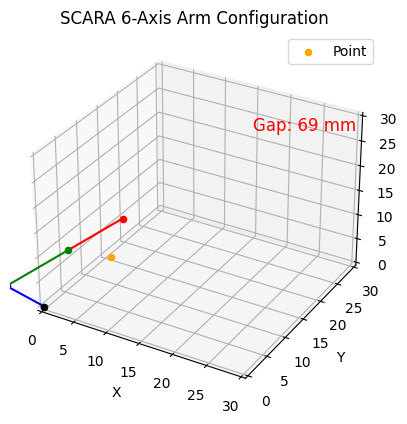

Saved image to 24.png
Robot Angles: 86.18592516570965, 81.80608421451768, 75.0, 90, 123.025743058773
Sides: a=15.0, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=128.34598132099222, angle_bc=45.0, angle_cd=146.73234197383658, angle_ad=39.92167670517123
Robot angles: axis1=90.0 axis2=128.34598132099222, axis3=45.0, axis4=146.73234197383658
First Line: 0, -7, 9
Second Line: 0, 5, 7
Third Line: 0, 17, 6
Gap Distance: 70 mm


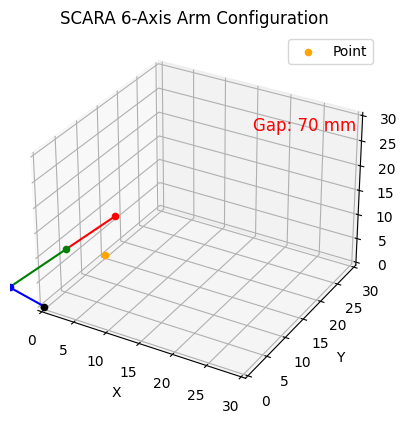

Saved image to 25.png
Robot Angles: 90.0, 81.65401867900778, 75.0, 90, 123.26765802616342
Sides: a=16.0, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=123.70187741979711, angle_bc=45.0, angle_cd=154.21389298376442, angle_ad=37.084229596438455
Robot angles: axis1=90.0 axis2=123.70187741979711, axis3=45.0, axis4=154.21389298376442
First Line: 0, -6, 9
Second Line: 0, 6, 7
Third Line: 0, 18, 5
Gap Distance: 54 mm


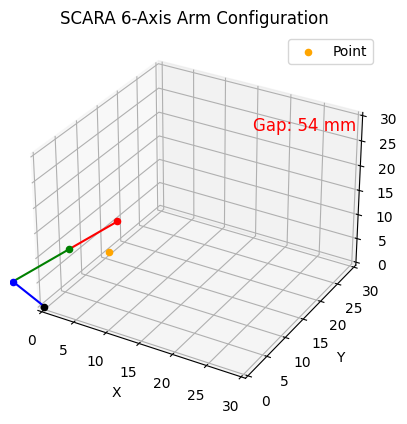

Saved image to 26.png
Robot Angles: 90.0, 86.29812258020289, 75.0, 90, 115.78610701623558
Sides: a=17.0, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=118.83773463401754, angle_bc=45.0, angle_cd=162.23359348612257, angle_ad=33.92867187985987
Robot angles: axis1=90.0 axis2=118.83773463401754, axis3=45.0, axis4=162.23359348612257
First Line: 0, -5, 10
Second Line: 0, 6, 6
Third Line: 0, 18, 3
Gap Distance: 37 mm


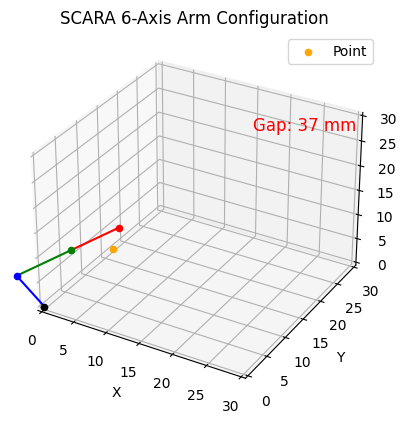

Saved image to 27.png
Robot Angles: 90.0, 91.16226536598246, 75.0, 90, 107.76640651387743
Sides: a=18.0, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=113.63314664117635, angle_bc=45.0, angle_cd=170.98560653713653, angle_ad=30.381246821687125
Robot angles: axis1=90.0 axis2=113.63314664117635, axis3=45.0, axis4=170.98560653713653
First Line: 0, -4, 10
Second Line: 0, 7, 6
Third Line: 0, 18, 1
Gap Distance: 19 mm


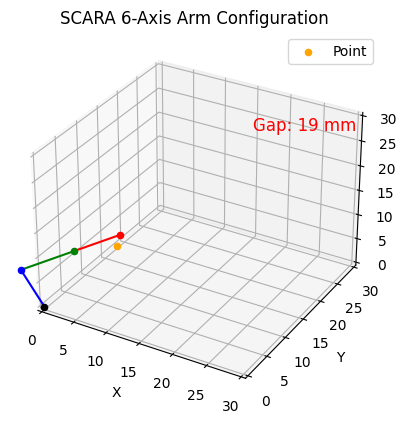

Saved image to 28.png
Robot Angles: 90.0, 96.36685335882365, 75.0, 90, 99.01439346286347
Sides: a=19.0, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=107.89659469521466, angle_bc=45.0, angle_cd=180.79693598663283, angle_ad=26.3064693181525
Calculated angles: angle_ab=107.83250845684883, angle_bc=47.0, angle_cd=176.7552623228367, angle_ad=28.4122292203145
Robot angles: axis1=90.0 axis2=107.83250845684883, axis3=47.0, axis4=176.7552623228367
First Line: 0, -3, 11
Second Line: 0, 8, 5
Third Line: 0, 19, 0
Gap Distance: 6 mm


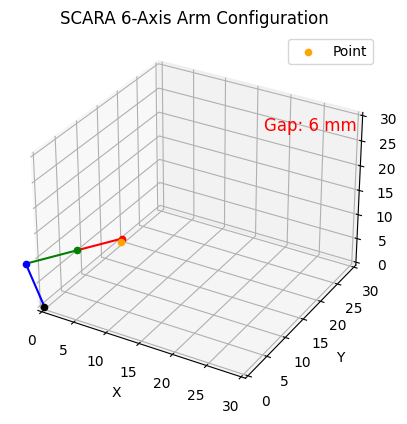

Saved image to 29.png
Robot Angles: 90.0, 102.16749154315117, 77.0, 90, 93.2447376771633
Sides: a=20.0, b=12.0, c=13.1, d=12.3
Calculated angles: angle_ab=101.26310275553026, angle_bc=45.0, angle_cd=192.30975633617754, angle_ad=21.4271409082922
Calculated angles: angle_ab=101.84416742021548, angle_bc=47.0, angle_cd=187.33856060817618, angle_ad=23.81727197160834
Calculated angles: angle_ab=102.11894192284372, angle_bc=49.00000000000001, angle_cd=182.81161960126616, angle_ad=26.069438475890106
Calculated angles: angle_ab=102.15505015001317, angle_bc=51.00000000000001, angle_cd=178.62943614002955, angle_ad=28.215513709957285
Robot angles: axis1=90.0 axis2=102.15505015001317, axis3=51.00000000000001, axis4=178.62943614002955
First Line: 0, -2, 11
Second Line: 0, 9, 5
Third Line: 0, 20, 0
Gap Distance: 2 mm


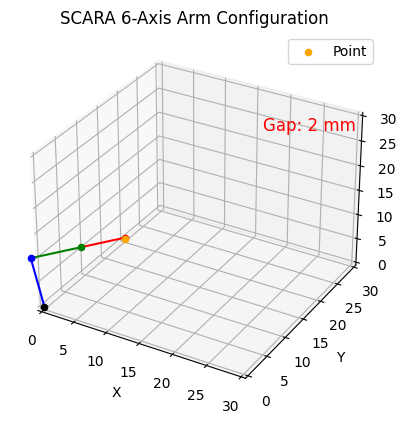

Saved image to 30.png
Robot Angles: 90.0, 107.84494984998683, 81.0, 90, 91.37056385997045
processing 31 images into a 20 fps video


<ipython-input-32-00485df5a98e>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  video_frames = [imageio.imread(str(image)) for image in IMAGES]


Video saved as: rectangle_videos/robot_video.mp4
Image 1 saved as: rectangle_images/image_0.png
Image 2 saved as: rectangle_images/image_1.png
Image 3 saved as: rectangle_images/image_2.png
Image 4 saved as: rectangle_images/image_3.png
Image 5 saved as: rectangle_images/image_4.png


<ipython-input-32-00485df5a98e>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(str(image_path))  # Read image data


Image 6 saved as: rectangle_images/image_5.png
Image 7 saved as: rectangle_images/image_6.png
Image 8 saved as: rectangle_images/image_7.png
Image 9 saved as: rectangle_images/image_8.png
Image 10 saved as: rectangle_images/image_9.png
Image 11 saved as: rectangle_images/image_10.png
Image 12 saved as: rectangle_images/image_11.png
Image 13 saved as: rectangle_images/image_12.png
Image 14 saved as: rectangle_images/image_13.png
Image 15 saved as: rectangle_images/image_14.png
Image 16 saved as: rectangle_images/image_15.png
Image 17 saved as: rectangle_images/image_16.png
Image 18 saved as: rectangle_images/image_17.png
Image 19 saved as: rectangle_images/image_18.png
Image 20 saved as: rectangle_images/image_19.png
Image 21 saved as: rectangle_images/image_20.png
Image 22 saved as: rectangle_images/image_21.png
Image 23 saved as: rectangle_images/image_22.png
Image 24 saved as: rectangle_images/image_23.png
Image 25 saved as: rectangle_images/image_24.png
Image 26 saved as: rectangle_

In [ ]:
# import requests
# import json

data = {
    "delay": 0.05,
    "coordinates": []
}

# Define the dimensions of the rectangle
# width = 10
# height = 5

# # Starting coordinates
# x_start = 0
# y_start = 10
# z = 0

width = 10
height = 5


# Starting coordinates
x_start = 0
y_start = 20
z = 0

# Generate coordinates for the first side of the rectangle
for i in range(width):
    data["coordinates"].append({"x": x_start + i, "y": y_start, "z": z})

# Move along the second side of the rectangle
for i in range(height):
    data["coordinates"].append({"x": x_start + width, "y": y_start - i, "z": z})

# Move along the third side of the rectangle
for i in range(width):
    data["coordinates"].append({"x": x_start + width - i, "y": y_start - height, "z": z})

# Move along the fourth side of the rectangle
for i in range(height):
    data["coordinates"].append({"x": x_start, "y": y_start - height + i, "z": z})

# Add the starting point to close the rectangle
data["coordinates"].append({"x": x_start, "y": y_start, "z": z})


json_data = json.dumps(data, indent=4)

# # Print JSON data
print(json_data)









images, delay = process_coordinates(data)

video = create_rectangle_video(images, delay)


### rectangle video

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

NameError: name 'video' is not defined

### trangle coordiantes

In [ ]:
import os
import imageio

def create_triangle_video(IMAGES, delay=1, video_output_dir='triangle_videos', images_output_dir='triangle_images'):
    # Create output directories if they don't exist
    if not os.path.exists(video_output_dir):
        os.makedirs(video_output_dir)
    if not os.path.exists(images_output_dir):
        os.makedirs(images_output_dir)

    # Create an imageio writer to save the frames as a video
    fps = int(1/delay)
    print(f"processing {len(IMAGES)} images into a {fps} fps video")
    video_filename = os.path.join(video_output_dir, 'robot_video.mp4')

    # Read images and create video frames
    video_frames = [imageio.imread(str(image)) for image in IMAGES]

    # Create video
    imageio.mimsave(video_filename, video_frames, fps=10)

    print(f'Video saved as: {video_filename}')

    # Saving images separately
    for idx, image_path in enumerate(IMAGES):
        image = imageio.imread(str(image_path))  # Read image data
        image_filename = os.path.join(images_output_dir, f'image_{idx}.png')
        imageio.imwrite(image_filename, image)
        print(f'Image {idx+1} saved as: {image_filename}')

    return video_filename


In [ ]:
data = {
    "delay": 0.05,
    "coordinates": []
}

# Define the side length of the triangle
side_length = 10

# Starting coordinates
x_start = 0
y_start = 10
z = 0

# Generate coordinates for one side of the triangle
for i in range(side_length + 1):
    data["coordinates"].append({"x": x_start + i, "y": y_start, "z": z})

# Move along the next side of the triangle
for i in range(1, side_length + 1):
    data["coordinates"].append({"x": x_start + side_length, "y": y_start + i, "z": z})

# Move along the third side of the triangle
for i in range(1, side_length):
    data["coordinates"].append({"x": x_start + side_length - i, "y": y_start + side_length - i, "z": z})

# Add the starting point to close the triangle
data["coordinates"].append({"x": x_start, "y": y_start, "z": z})


json_data = json.dumps(data, indent=4)

# # Print JSON data
print(json_data)

images, delay = process_coordinates(data)
video = create_triangle_video(images, delay)

NameError: name 'L1' is not defined

### trangle video

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### circle coordinates

In [ ]:
import os
import imageio

def create_circle_video(IMAGES, delay=1, video_output_dir='circle_videos', images_output_dir='circle_images'):
    # Create output directories if they don't exist
    if not os.path.exists(video_output_dir):
        os.makedirs(video_output_dir)
    if not os.path.exists(images_output_dir):
        os.makedirs(images_output_dir)

    # Create an imageio writer to save the frames as a video
    fps = int(1/delay)
    print(f"processing {len(IMAGES)} images into a {fps} fps video")
    video_filename = os.path.join(video_output_dir, 'robot_video.mp4')

    # Read images and create video frames
    video_frames = [imageio.imread(str(image)) for image in IMAGES]

    # Create video
    imageio.mimsave(video_filename, video_frames, fps=10)

    print(f'Video saved as: {video_filename}')

    # Saving images separately
    for idx, image_path in enumerate(IMAGES):
        image = imageio.imread(str(image_path))  # Read image data
        image_filename = os.path.join(images_output_dir, f'image_{idx}.png')
        imageio.imwrite(image_filename, image)
        print(f'Image {idx+1} saved as: {image_filename}')

    return video_filename


In [ ]:

import json

data = {
    "delay": 0.05,
    "coordinates": []
}

# # Define the circle parameters
# radius = 10
# num_points = 36

# # Starting coordinates
# x_center = 0
# y_center = 0
# z = 0

# Define the circle parameters
radius = 6
num_points = 20

# Starting coordinates
x_center = 10
y_center = 10
z = 0

# Generate coordinates for the circle
for i in range(num_points):
    theta = 2 * math.pi * i / num_points
    x = x_center + radius * math.cos(theta)
    y = y_center + radius * math.sin(theta)
    data["coordinates"].append({"x": x, "y": y, "z": z})

# Add the starting point to close the circle
data["coordinates"].append({"x": x_center + radius, "y": y_center, "z": z})

json_data = json.dumps(data, indent=4)

# # Print JSON data
print(json_data)

# Process coordinates and create video
images, delay = process_coordinates(data)
video = create_circle_video(images, delay)


{'delay': 0.05, 'coordinates': [{'x': 16.0, 'y': 10.0, 'z': 0}, {'x': 15.706339097770922, 'y': 11.854101966249685, 'z': 0}, {'x': 14.854101966249685, 'y': 13.526711513754838, 'z': 0}, {'x': 13.526711513754838, 'y': 14.854101966249685, 'z': 0}, {'x': 11.854101966249685, 'y': 15.706339097770922, 'z': 0}, {'x': 10.0, 'y': 16.0, 'z': 0}, {'x': 8.145898033750315, 'y': 15.706339097770922, 'z': 0}, {'x': 6.473288486245162, 'y': 14.854101966249685, 'z': 0}, {'x': 5.145898033750316, 'y': 13.52671151375484, 'z': 0}, {'x': 4.293660902229079, 'y': 11.854101966249685, 'z': 0}, {'x': 4.0, 'y': 10.0, 'z': 0}, {'x': 4.293660902229077, 'y': 8.145898033750319, 'z': 0}, {'x': 5.145898033750314, 'y': 6.473288486245162, 'z': 0}, {'x': 6.473288486245161, 'y': 5.145898033750316, 'z': 0}, {'x': 8.145898033750315, 'y': 4.293660902229079, 'z': 0}, {'x': 9.999999999999998, 'y': 4.0, 'z': 0}, {'x': 11.854101966249683, 'y': 4.293660902229078, 'z': 0}, {'x': 13.526711513754837, 'y': 5.145898033750314, 'z': 0}, {'x'

NameError: name 'L1' is not defined

### circle video

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### square coordinates

In [ ]:
import os
import imageio

def create_square_video(IMAGES, delay=1, video_output_dir='square_videos', images_output_dir='square_images'):
    # Create output directories if they don't exist
    if not os.path.exists(video_output_dir):
        os.makedirs(video_output_dir)
    if not os.path.exists(images_output_dir):
        os.makedirs(images_output_dir)

    # Create an imageio writer to save the frames as a video
    fps = int(1/delay)
    print(f"processing {len(IMAGES)} images into a {fps} fps video")
    video_filename = os.path.join(video_output_dir, 'robot_video.mp4')

    # Read images and create video frames
    video_frames = [imageio.imread(str(image)) for image in IMAGES]

    # Create video
    imageio.mimsave(video_filename, video_frames, fps=10)

    print(f'Video saved as: {video_filename}')

    # Saving images separately
    for idx, image_path in enumerate(IMAGES):
        image = imageio.imread(str(image_path))  # Read image data
        image_filename = os.path.join(images_output_dir, f'image_{idx}.png')
        imageio.imwrite(image_filename, image)
        print(f'Image {idx+1} saved as: {image_filename}')

    return video_filename


In [ ]:
data = {
    "delay": 0.05,
    "coordinates": []
}

# Define the side length of the square
side_length = 10

# Starting coordinates
x_start = 0
y_start = 10
z = 0

# Generate coordinates for one side of the square
for i in range(side_length):
    data["coordinates"].append({"x": x_start, "y": y_start + i * 0.5, "z": z})

# Move along the next side of the square
for i in range(side_length):
    data["coordinates"].append({"x": x_start + i * 0.5, "y": y_start + side_length * 0.5, "z": z})

# Move along the third side of the square
for i in range(side_length):
    data["coordinates"].append({"x": x_start + side_length * 0.5, "y": y_start + side_length * 0.5 - i * 0.5, "z": z})

# Move along the fourth side of the square
for i in range(side_length):
    data["coordinates"].append({"x": x_start + side_length * 0.5 - i * 0.5, "y": y_start, "z": z})

# Add the starting point to close the square
data["coordinates"].append({"x": x_start, "y": y_start, "z": z})
json_data = json.dumps(data, indent=4)

# # Print JSON data
print(json_data)
images, delay = process_coordinates(data)
video = create_square_video(images, delay)


### square video

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)